In [1]:
import re
import json
import os
import shutil

from datetime import datetime
import IPython.display as ipd

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import datasets as hfd

import transformers
from transformers import (
    Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments, Trainer
)

import torch
print(torch.cuda.is_available())

True


In [2]:
from src.data_collator import DataCollatorCTCWithPadding
from src.metrics import WerMetric, parse_w2v2_predictions_batched

In [3]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [4]:
# DATA_ROOT_DP = os.environ['DATA_HOME']
SSD_DATA_ROOT_DP = os.environ['SSD_DATA_HOME']

In [5]:
CV_PROCESSED_2_DP = f'{SSD_DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19__be__processed__2'

In [6]:
ds = hfd.load_from_disk(CV_PROCESSED_2_DP)
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 314305
    })
    dev: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15803
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15801
    })
})

In [7]:
# # select subset of data
# ds['train'] = ds['train'].select(range(300))
# ds['dev'] = ds['dev'].select(range(100))
# ds

In [8]:
processor = Wav2Vec2Processor.from_pretrained('artifacts/processor')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [10]:
wer_metric = hfd.load_metric("wer")

In [11]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [12]:
vocab = processor.tokenizer.get_vocab()
pd.Series(vocab).to_frame().T

,',i,а,б,в,г,д,е,ж,з,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,ы,ь,э,ю,я,ё,і,ў,|,[UNK],[PAD],<s>,</s>
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,0,35,36,37,38


In [13]:
vocab_size = len(processor.tokenizer.get_vocab())
logger.info(f'vocab_size: {vocab_size}')

2022-03-30 01:26:27,069:STT:INFO:vocab_size: 39


In [14]:
pretrained_checkpoint_dp = 'train/run_1/checkpoint-6480'
print(os.listdir(pretrained_checkpoint_dp))

['scheduler.pt', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'scaler.pt', 'config.json', 'rng_state.pth', 'optimizer.pt', 'trainer_state.json']


In [15]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-base",
#     ctc_loss_reduction="mean", 
#     pad_token_id=processor.tokenizer.pad_token_id,
#     vocab_size=vocab_size
# )

In [16]:
# continue from checkpoint
model = Wav2Vec2ForCTC.from_pretrained(pretrained_checkpoint_dp)

In [ ]:
model.freeze_feature_extractor()

In [18]:
model.device

device(type='cpu')

In [19]:
now_str = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_out_dp = os.path.join('train', now_str)
os.makedirs(train_out_dp, exist_ok=True)
print(f'will save train output to: "{train_out_dp}"')

logs_dp = os.path.join(train_out_dp, 'logs')
print(f'will save train logs to: "{logs_dp}"')

will save train output to: "train/2022-03-30-01-26-34"
will save train logs to: "train/2022-03-30-01-26-34/logs"


In [20]:
steps = 1080

training_args = TrainingArguments(
    output_dir=train_out_dp,
    logging_dir=logs_dp,

    num_train_epochs=1,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    save_total_limit=None,
    load_best_model_at_end=True,
    metric_for_best_model='wer',
    greater_is_better=False,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    group_by_length=False,
    gradient_checkpointing=True, 
    
    learning_rate=1e-4,
    weight_decay=0.005,
    warmup_steps=1080,
)

In [21]:
transformers.logging.set_verbosity_info()

In [22]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds['train'],
    eval_dataset=ds['dev'],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


## train

In [ ]:
trainer.train()

In [24]:
torch.cuda.empty_cache()

## evaluate

In [10]:
finetuned_checkpoint_dp = 'train/2022-03-30-01-26-34/checkpoint-6480'
print(f'reading model from: "{finetuned_checkpoint_dp}"')
model = Wav2Vec2ForCTC.from_pretrained(finetuned_checkpoint_dp)
model.to('cuda');

reading model from: "train/2022-03-30-01-26-34/checkpoint-6480"


In [11]:
wer_metric_2 = WerMetric(processor=processor)  # TODO: rename

In [12]:
training_args = TrainingArguments(
    output_dir='eval_output',
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metric_2.compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [ ]:
pred_out = trainer.predict(ds['test'])

In [14]:
pred_out.metrics

{'test_loss': 0.1495739221572876,
 'test_wer': 0.23438568674998445,
 'test_runtime': 626.0028,
 'test_samples_per_second': 25.241,
 'test_steps_per_second': 0.527}

In [58]:
print(f"Test WER using Acoustic Model only: {pred_out.metrics['test_wer'] :.3f}")

Test WER using Acoustic Model only: 0.234


### examples of model predictions

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1);

In [17]:
parsed_preds = parse_w2v2_predictions_batched(pred_out, processor=processor)

In [22]:
df_results = pd.DataFrame(parsed_preds)[['text', 'pred_text']]
print(df_results.shape)

df_results['success'] = (df_results['text'] == df_results['pred_text']).astype('int')
df_results['wer'] = df_results.apply(
    lambda row: 
    wer_metric_2.wer_metric.compute(
        predictions=[row['pred_text']],
        references=[row['text']]
    ),
    axis=1
)

df_results.head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.000000
1,быў разбураны пры вызваленні горада ад нямецкафашысцкіх захопнікаў,быў разбураны пры вызваленні горада аднямецка фашынцкіх захопнікаў,0,0.250000
2,далейшае супрацоўніцтва паміж нямецкім і савецкім прыняло форму абмену польскіх ваеннапалонных,далейша супрацоніцтваў мічнямецкім савецкім пыняўа форамуў абменну польскіх ваеннапоглам,0,0.818182
3,цвіценне працягваецца з мая да позняй восені,цвіценне працягваецца з мая да позняй восені,1,0.000000
4,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,таксама пройдзе канферэнцыя фестываль і мастацкая выстала,0,0.142857


In [25]:
df_results.shape

(15801, 4)

In [34]:
success_stats = df_results['success'].value_counts(dropna=False, normalize=True)
success_stats = success_stats.to_frame('fraction').join(
    df_results['success'].value_counts(dropna=False).rename('abs')
)
success_stats

,fraction,abs
0,0.712044,11251
1,0.287956,4550


In [39]:
print(f'Rate of fully recognized clips from Test set using Acoustic Model only: '
      f"{success_stats.loc[1, 'fraction'] :.3%}")

Rate of fully recognized clips from Test set using Acoustic Model only: 28.796%


In [40]:
df_results.sort_values('wer', ascending=False).head()

,text,pred_text,success,wer
9235,елі гэтую страву звычайна разагрэтай,і ле гэтуую страву звычэйна раза гэта,0,1.200000
5359,асудзіў масонства сацыялізм камунізм нігілізм,аслудзіў у масорыства сацыялізмы камунізма негілізм,0,1.200000
10354,улезла глыбей ямачку сабе вылежала,у лезла я глабе ямошку сабе вылежыла,0,1.200000
8877,дрэвы маюць гладкую светлашэрую кару,трэба мач ладкую светла шэрую каромну,0,1.200000
824,нахіліўшы галаву абдзіраловіч прачытаў цісненне капітал,нахілевы жа халавў ціравовячы пачытаў ціснення капітаў,0,1.166667


In [41]:
df_results.sort_values('wer', ascending=True).head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.0
8018,а выйшла што зусім не хочацца есці,а выйшла што зусім не хочацца есці,1,0.0
8017,і таму кажа спакойна вылучылі свайго кандыдата,і таму кажа спакойна вылучылі свайго кандыдата,1,0.0
8016,а мне дакладна скажуць што і так нармальна,а мне дакладна скажуць што і так нармальна,1,0.0
8015,не паедзеш за мяжу,не паедзеш за мяжу,1,0.0


In [59]:
df_results.iloc[[12, 9532, 9533,12305]]

,text,pred_text,success,wer
12,толькі ў раёне таксама нашы людзі вясковыя,толькі ў раёне таксама наш людзі вясковая,0,0.285714
9532,у яго нават ёсць сольныя выступы,у яго нават ёсць сэльныя выступы,0,0.166667
9533,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,наўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,0,0.222222
12305,шлюбам папярэднічалі перагаворы паміж сем'ямі,шлюбам папярэднічалі перагаворы паміж сем'ямі,1,0.000000


### wer stats for test set items

count    15801.000000
mean         0.227199
std          0.213068
min          0.000000
25%          0.000000
50%          0.200000
75%          0.363636
max          1.200000
Name: wer, dtype: float64

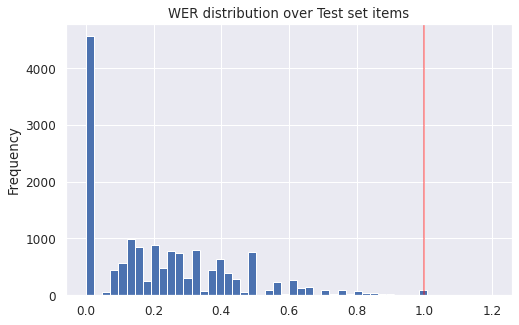

In [54]:
display(df_results['wer'].describe())

df_results['wer'].plot.hist(bins=50, figsize=(8, 5));
plt.title('WER distribution over Test set items');
plt.axvline(1, color='red', alpha=0.5);